<a href="https://colab.research.google.com/github/Alyssonmach/tensorflow-computer-vision/blob/main/week1/w1_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic transfer learning with cats and dogs data



### Import tensorflow

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

### Import modules and download the cats and dogs dataset.

In [2]:
import urllib.request
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


%matplotlib inline

In [3]:
data_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip"
data_file_name = "catsdogs.zip"
download_dir = '/tmp/'
urllib.request.urlretrieve(data_url, data_file_name)
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

Check that the dataset has the expected number of examples.

In [4]:
print("Number of cat images:",len(os.listdir('/tmp/PetImages/Cat/')))
print("Number of dog images:", len(os.listdir('/tmp/PetImages/Dog/')))

Number of cat images: 12501
Number of dog images: 12501


Create some folders that will store the training and test data.
- There will be a training folder and a testing folder.
- Each of these will have a subfolder for cats and another subfolder for dogs.

In [5]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

### Split data into training and test sets

- The following code put first checks if an image file is empty (zero length)
- Of the files that are not empty, it puts 90% of the data into the training set, and 10% into the test set.

In [6]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

In [7]:
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

In [8]:
split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Check that the training and test sets are the expected lengths.

In [9]:
print("Number of training cat images", len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print("Number of training dog images", len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print("Number of testing cat images", len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print("Number of testing dog images", len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

Number of training cat images 11250
Number of training dog images 11250
Number of testing cat images 1250
Number of testing dog images 1250


### Data augmentation (try adjusting the parameters)!

Here, you'll use the `ImageDataGenerator` to perform data augmentation.  
- Things like rotating and flipping the existing images allows you to generate training data that is more varied, and can help the model generalize better during training.  
- You can also use the data generator to apply data augmentation to the validation set.

You can use the default parameter values for a first pass through this lab.
- Later, try to experiment with the parameters of `ImageDataGenerator` to improve the model's performance.
- Try to drive reach 99.9% validation accuracy or better.

In [10]:
TRAINING_DIR = '/tmp/cats-v-dogs/training/'

train_datagen = ImageDataGenerator(rescale=1./255., rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, batch_size=100, class_mode='binary', target_size=(150, 150))

VALIDATION_DIR = '/tmp/cats-v-dogs/testing/'

validation_datagen = ImageDataGenerator(rescale=1./255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, batch_size=100, class_mode='binary',
                                                              target_size=(150, 150))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


### Get and prepare the model

You'll be using the `InceptionV3` model.  
- Since you're making use of transfer learning, you'll load the pre-trained weights of the model.
- You'll also freeze the existing layers so that they aren't trained on your downstream task with the cats and dogs data.
- You'll also get a reference to the last layer, 'mixed7' because you'll add some layers after this last layer.

In [11]:
weights_url = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_file = 'inception_v3.h5'
urllib.request.urlretrieve(weights_url, weights_file)

('inception_v3.h5', <http.client.HTTPMessage at 0x7fca735d3490>)

In [12]:
pre_trained_model = InceptionV3(input_shape=(150,150,3), include_top=False, weights=None)

pre_trained_model.load_weights(weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer shape:  (None, 7, 7, 768)


### Add layers
Add some layers that you will train on the cats and dogs data.
- `Flatten`: This will take the output of the `last_layer` and flatten it to a vector.
- `Dense`: You'll add a dense layer with a relu activation.
- `Dense`: After that, add a dense layer with a sigmoid activation.  The sigmoid will scale the output to range from 0 to 1, and allow you to interpret the output as a prediction between two categories (cats or dogs).

Then create the model object.

In [13]:
x = layers.Flatten()(last_output)
x = layers.Dense(units=1024, activation=tf.nn.relu)(x)
x = layers.Dense(units=1, activation=tf.nn.sigmoid)(x)

model = Model(inputs=pre_trained_model.input, outputs = x)

### Train the model
Compile the model, and then train it on the test data using `model.fit`
- Feel free to adjust the number of epochs.  This project was originally designed with 20 epochs.
- For the sake of time, you can use fewer epochs (2) to see how the code runs.
- You can ignore the warnings about some of the images having corrupt EXIF data. Those will be skipped.

In [14]:
model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='binary_crossentropy', metrics=['acc'])

In [15]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=2, verbose=1)

Epoch 1/2
189/225 [========================>.....] - ETA: 25s - loss: 0.2430 - acc: 0.9059

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

225/225 [==============================] - 203s 758ms/step - loss: 0.2315 - acc: 0.9091 - val_loss: 0.1219 - val_acc: 0.9508
Epoch 2/2
225/225 [==============================] - 166s 739ms/step - loss: 0.1495 - acc: 0.9364 - val_loss: 0.0946 - val_acc: 0.9688


### Visualize the training and validation accuracy

You can see how the training and validation accuracy change with each epoch on an x-y plot.

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

<Figure size 432x288 with 0 Axes>

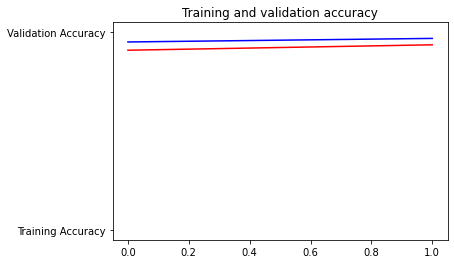

<Figure size 432x288 with 0 Axes>

In [17]:
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()

### Predict on a test image

You can upload any image and have the model predict whether it's a dog or a cat.
- Find an image of a dog or cat
- Run the following code cell.  It will ask you to upload an image.
- The model will print "is a dog" or "is a cat" depending on the model's prediction.

In [18]:
uploaded = files.upload()

Saving cat.jpg to cat.jpg


In [19]:
for fn in uploaded.keys():

  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

[[0.]]
[0.]
cat.jpg is a cat
